In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot.inputs.tf_keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
# Paths and parameters
parent_dir = os.path.dirname(os.getcwd())
best_cars_model_path = 'best_cars_model.h5'
train_path = os.path.join(parent_dir, 'data', 'train')
valid_path = os.path.join(parent_dir, 'data', 'valid')
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
N_EPOCHS = 150

# Load annotations
column_names = ['filename', 'x_min', 'y_min', 'x_max', 'y_max', 'class']
train_annotations = pd.read_csv(os.path.join(train_path, '_annotations.csv'), header=None, names=column_names)
valid_annotations = pd.read_csv(os.path.join(valid_path, '_annotations.csv'), header=None, names=column_names)
mean = np.array([0.4708, 0.4602, 0.4550])
std = np.array([0.2593, 0.2584, 0.2634])

In [17]:
def select_random_classes(annotations, num_classes):
  unique_classes = annotations['class'].unique()
  selected_classes = np.random.choice(unique_classes, size=num_classes, replace=False)
  return selected_classes

def filter_annotations(annotations, selected_classes):
  return annotations[annotations['class'].isin(selected_classes)]

def create_generator(datagen, annotations, path, shuffle=True, max_num_classes=None):
  if max_num_classes:
    selected_classes = select_random_classes(annotations, num_classes=max_num_classes)
    annotations = filter_annotations(annotations, selected_classes)
  else:
    selected_classes = ['Volvo 240 Sedan 1993', 'Chevrolet Corvette ZR1 2012', 'Audi S5 Coupe 2012', 'Lamborghini Reventon Coupe 2008', 'Hyundai Veloster Hatchback 2012', 'Ford E-Series Wagon Van 2012', 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'AM General Hummer SUV 2000', 'Hyundai Sonata Hybrid Sedan 2012', 'Ford Ranger SuperCab 2011', 'Audi S5 Convertible 2012', 'Infiniti QX56 SUV 2011', 'Chrysler Town and Country Minivan 2012', 'Ford Expedition EL SUV 2009', 'BMW X5 SUV 2007', 'smart fortwo Convertible 2012', 'Cadillac CTS-V Sedan 2012', 'Chevrolet Monte Carlo Coupe 2007', 'Hyundai Santa Fe SUV 2012', 'Land Rover Range Rover SUV 2012']
    annotations = filter_annotations(annotations, selected_classes)

  return datagen.flow_from_dataframe(
    annotations,
    directory=path,
    x_col='filename',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=shuffle
  )

In [18]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5]
)
train_datagen.mean = mean
train_datagen.std = std

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_datagen.mean = mean
test_datagen.std = std

train_generator = create_generator(train_datagen, train_annotations, train_path)
test_generator = create_generator(test_datagen, valid_annotations, valid_path, shuffle=False)

Found 1962 validated image filenames belonging to 20 classes.
Found 158 validated image filenames belonging to 20 classes.


In [19]:
train_generator.class_indices

{'AM General Hummer SUV 2000': 0,
 'Audi S5 Convertible 2012': 1,
 'Audi S5 Coupe 2012': 2,
 'BMW X5 SUV 2007': 3,
 'Cadillac CTS-V Sedan 2012': 4,
 'Chevrolet Corvette ZR1 2012': 5,
 'Chevrolet Monte Carlo Coupe 2007': 6,
 'Chrysler Town and Country Minivan 2012': 7,
 'Ford E-Series Wagon Van 2012': 8,
 'Ford Expedition EL SUV 2009': 9,
 'Ford Ranger SuperCab 2011': 10,
 'Hyundai Santa Fe SUV 2012': 11,
 'Hyundai Sonata Hybrid Sedan 2012': 12,
 'Hyundai Veloster Hatchback 2012': 13,
 'Infiniti QX56 SUV 2011': 14,
 'Lamborghini Gallardo LP 570-4 Superleggera 2012': 15,
 'Lamborghini Reventon Coupe 2008': 16,
 'Land Rover Range Rover SUV 2012': 17,
 'Volvo 240 Sedan 1993': 18,
 'smart fortwo Convertible 2012': 19}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


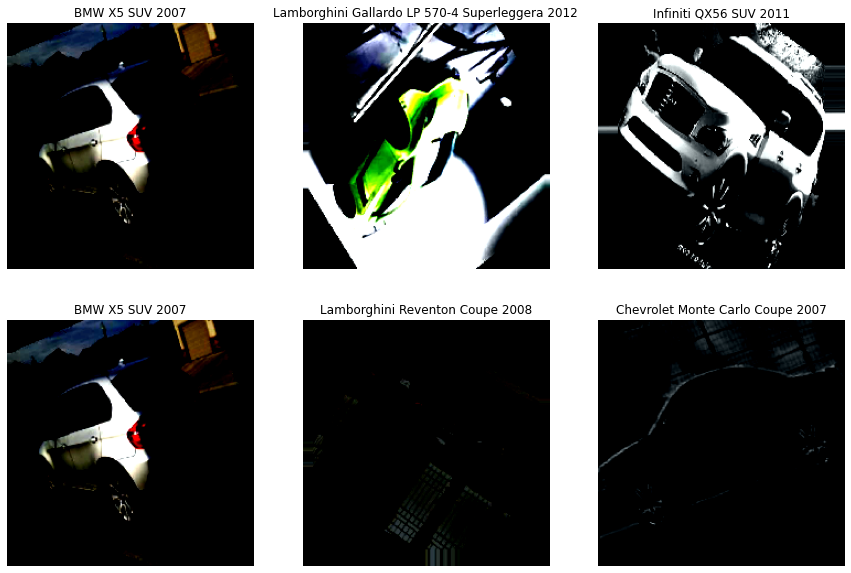

In [20]:
def plot_random_images_with_labels(generator, num_images=6):
    images, labels = next(generator)
    labels = np.argmax(labels, axis=1)

    class_indices = generator.class_indices
    class_labels = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(15, 10))
    
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[index])
        plt.title(class_labels[labels[index]])
        plt.axis('off')
    
    plt.show()

plot_random_images_with_labels(train_generator)

In [21]:
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  
  if fine_tune > 0:
    for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in base_model.layers:
      layer.trainable = False

  top_model = base_model.output
  top_model = Flatten()(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = BatchNormalization()(top_model)
  top_model = Dropout(0.5)(top_model)
  top_model = Dense(256, activation='relu')(top_model)
  top_model = BatchNormalization()(top_model)
  top_model = Dropout(0.5)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)
  
  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [22]:
# Defining model
num_classes = len(train_generator.class_indices)

model = create_model(input_shape=INPUT_SHAPE, n_classes=num_classes, optimizer=Adam(learning_rate=0.000006), fine_tune=3)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [23]:
# Callbacks
plot_loss = PlotLossesCallback()
checkpoint = ModelCheckpoint(best_cars_model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00000007, verbose=1)

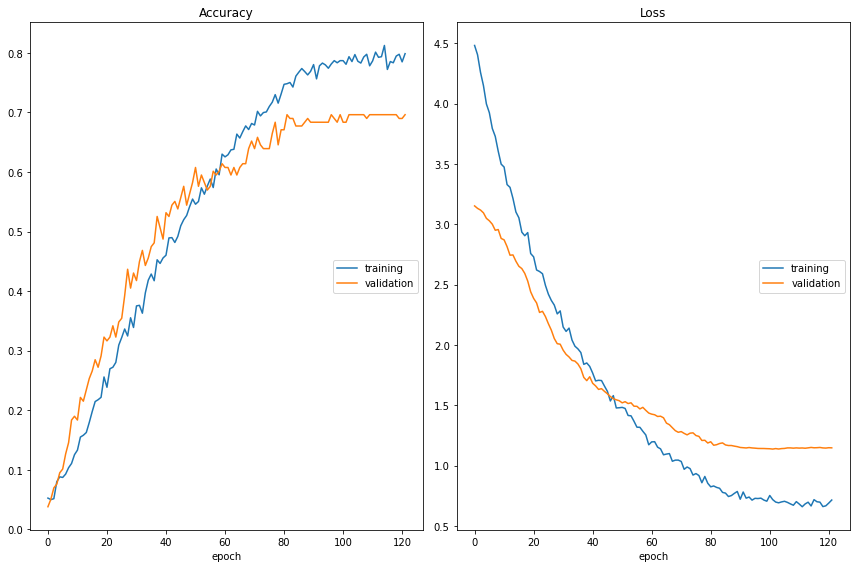

Accuracy
	training         	 (min:    0.050, max:    0.812, cur:    0.799)
	validation       	 (min:    0.038, max:    0.696, cur:    0.696)
Loss
	training         	 (min:    0.659, max:    4.481, cur:    0.715)
	validation       	 (min:    1.137, max:    3.152, cur:    1.147)

Epoch 00122: val_loss did not improve from 1.13691
Restoring model weights from the end of the best epoch.
62/62 [==============================] - 20s 318ms/step - loss: 0.7153 - acc: 0.7987 - val_loss: 1.1472 - val_acc: 0.6962
Epoch 00122: early stopping


In [24]:
# Train the model
history = model.fit(
  train_generator,
  epochs=N_EPOCHS,
  validation_data=test_generator,
  callbacks=[plot_loss, checkpoint, early_stop, reduce_lr],
  verbose=1
)

In [25]:
# Load the best model
best_model = load_model(best_cars_model_path)

# Evaluation
train_loss, train_acc = best_model.evaluate(train_generator, verbose=0)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_acc}')

test_loss, train_acc = best_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {train_acc}')

Train loss: 0.23473188593502967
Train accuracy: 0.9734963774681091
Test loss: 1.136910629272461
Test accuracy: 0.6835443377494812


In [26]:
# Prediction and metrics
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

In [27]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
confusion_mtx

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  6,  2,  0,  0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  2,  4,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,
         1,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  1,  0,  1,  1,  1,  0,  0,  1,  0,
         0,  0,  0,  0],
       [ 0,  0,  1,  1,  3,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  1,
         0,  0,  1,  0],
       [ 1,  0,  0,  0,  1,  6,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  2,  4,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1,  0,  1,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  0],
       [ 1,  0,  0,  0,  0,  0

In [28]:
print('Classification Report')
print(classification_report(true_classes, predicted_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.67      0.55      0.60        11
           2       0.50      0.44      0.47         9
           3       0.62      0.50      0.56        10
           4       0.60      0.33      0.43         9
           5       0.55      0.67      0.60         9
           6       1.00      0.44      0.62         9
           7       0.62      0.71      0.67         7
           8       1.00      1.00      1.00         6
           9       0.62      0.77      0.69        13
          10       0.83      0.71      0.77         7
          11       0.67      0.75      0.71         8
          12       0.40      0.33      0.36         6
          13       0.50      0.67      0.57         3
          14       0.50      0.33      0.40         6
          15       0.71      1.00      0.83         5
          16       0.83      0.83      0.83         6
     